In [ ]:
print('Welcome to facial-emotion.')

In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot
import seaborn as sns
from keras.api.utils import to_categorical
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
df = pd.read_csv('data/fer2013.csv')

r, c = df.shape
print(f'The dataset has {r} rows and {c} columns.\n')
df.head()

In [ ]:
df['Usage'].unique()

In [ ]:
df['emotion'].value_counts()

In [ ]:
df['emotion'].unique()

In [ ]:
emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [25]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

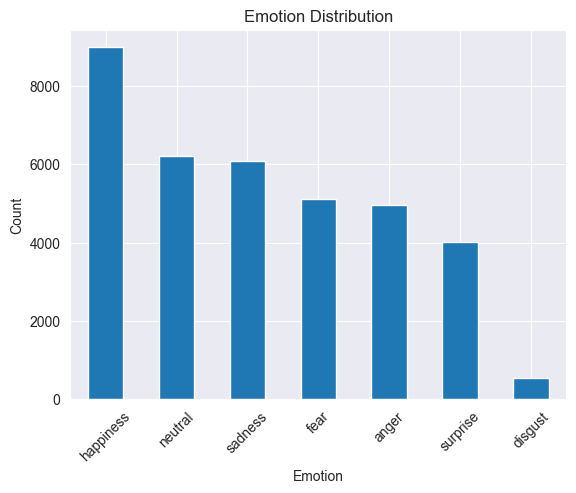

In [26]:
df['emotion'].map(emotion_label_to_text).value_counts().plot(kind='bar')

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.xticks(rotation=45)  # Rotate the x-axis labels if needed for better visibility

plt.show()

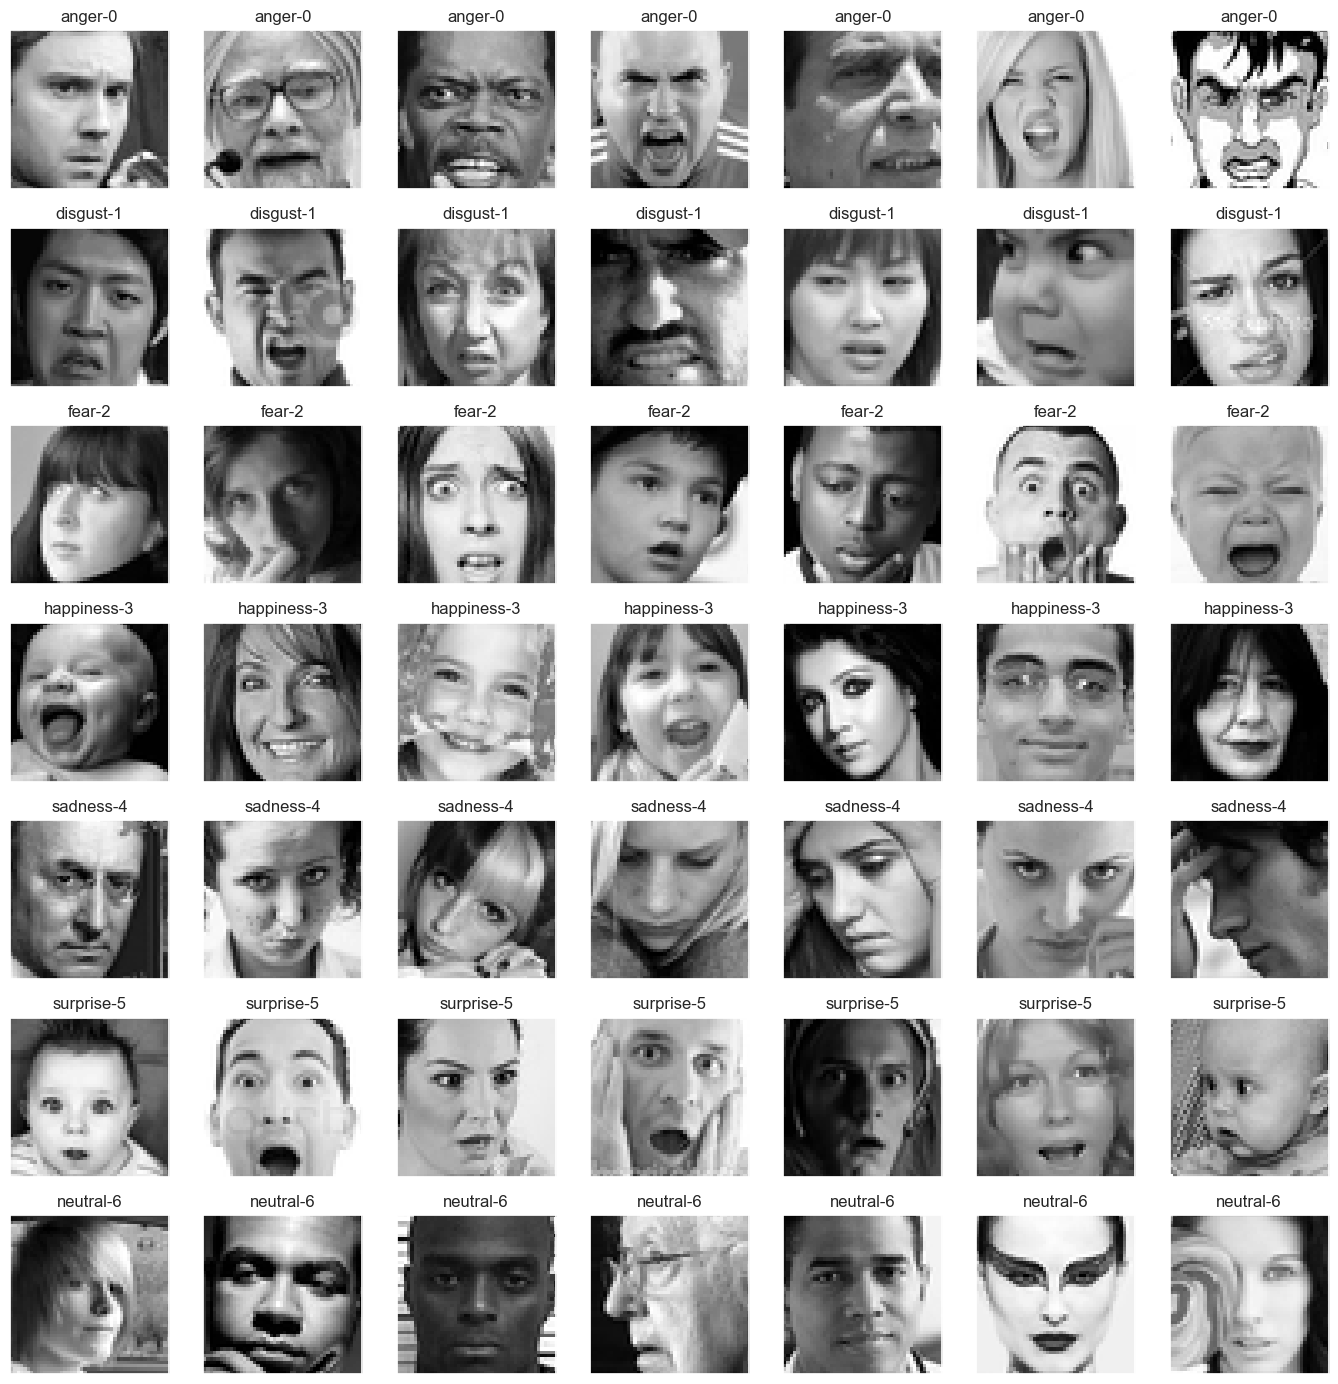

In [57]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [28]:
math.sqrt(len(df.pixels[2].split(' ')))

48.0

In [29]:
pixel_length = int(math.sqrt(len(df.pixels[1].split(' '))))

pixel_length

48

In [30]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(pixel_length, pixel_length, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

img_array.shape

(35887, 48, 48, 1)

In [31]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)

img_labels.shape

(35887, 7)

In [32]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

le_name_mapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [34]:
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [ ]:
# del df
# del img_array
# del img_labels

In [35]:
_, img_width, img_height, img_depth = X_train.shape
num_classes = y_train.shape[1]

img_width, img_height, img_depth, num_classes

(48, 48, 1, 7)

In [ ]:
# np.random.seed(42)
# surprise_idx = np.random.choice(np.where(y_train[:, 0] == 1)[0], size=1)
# happy_idx = np.random.choice(np.where(y_train[:, 1] == 1)[0], size=1)
# anger_idx = np.random.choice(np.where(y_train[:, 2] == 1)[0], size=1)
# sad_idx = np.random.choice(np.where(y_train[:, 3] == 1)[0], size=1)
# fear_idx = np.random.choice(np.where(y_train[:, 4] == 1)[0], size=1)
#
# fig = plt.figure(1, (6, 13))
#
# i = 0
# for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
#     for j in range(3):
#         i += 1
#         ax = plt.subplot(5, 3, i)
#         sample_img = X_train[idx][0, j, :, :, 0]
#         ax.imshow(sample_img, cmap='gray')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_title(name)

In [36]:
# Normalizing results, as neural networks are very sensitive to un-normalized data.
X_train = X_train / 255.
X_valid = X_test / 255.

X_train.mean(), X_train.std(), X_valid.mean(), X_valid.std()

(0.5075212, 0.2551314, 0.5062769, 0.25510627)

In [37]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    at least in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    # Use Input layer for defining the input shape
    net.add(
        Input(shape=(img_width, img_height, img_depth), name='input_layer')
    )

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net


In [38]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [39]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [40]:
batch_size = 32  # batch size of 32 performs the best.
epochs = 10  # should be 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])
# history = model.fit_generator(
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    # workers=4,
    # use_multiprocessing=True,
    # max_queue_size=10
)

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/10


/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 331s 325ms/step - accuracy: 0.2098 - loss: 2.3463 - val_accuracy: 0.3695 - val_loss: 1.6458 - learning_rate: 0.0010
Epoch 2/10
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 5:38 336ms/step - accuracy: 0.4375 - loss: 1.6272

/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4375 - loss: 1.6272 - val_accuracy: 0.3686 - val_loss: 1.6471 - learning_rate: 0.0010
Epoch 3/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 326s 323ms/step - accuracy: 0.3308 - loss: 1.6914 - val_accuracy: 0.4246 - val_loss: 1.5037 - learning_rate: 0.0010
Epoch 4/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5000 - loss: 1.3818 - val_accuracy: 0.4269 - val_loss: 1.5035 - learning_rate: 0.0010
Epoch 5/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 328s 325ms/step - accuracy: 0.4058 - loss: 1.5210 - val_accuracy: 0.4857 - val_loss: 1.3608 - learning_rate: 0.0010
Epoch 6/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3438 - loss: 1.3307 - val_accuracy: 0.4868 - val_loss: 1.3578 - learning_rate: 0.0010
Epoch 7/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 329s 326ms/step - accuracy: 0.4650 - loss: 1.4026 - val_accuracy: 0.5444 - val_loss: 1.1945 - learning_rate: 0.0010
Epoch 8/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.531

In [41]:
model.save("facial-model.keras")

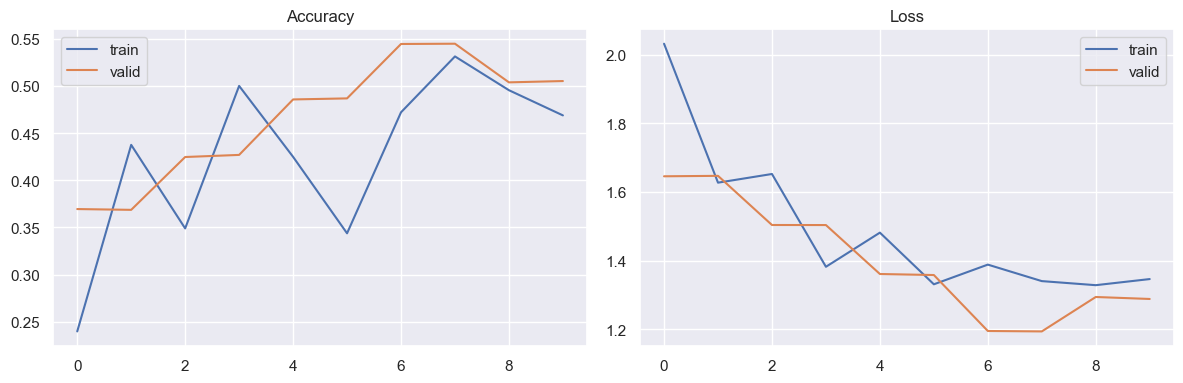

In [46]:
sns.set()

# Create the figure and subplots
fig = plt.figure(figsize=(12, 4))

# Accuracy plot
ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

# Loss plot
ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

# Save the plot and display it
plt.savefig('epoch_history_dcnn.png')
plt.show()


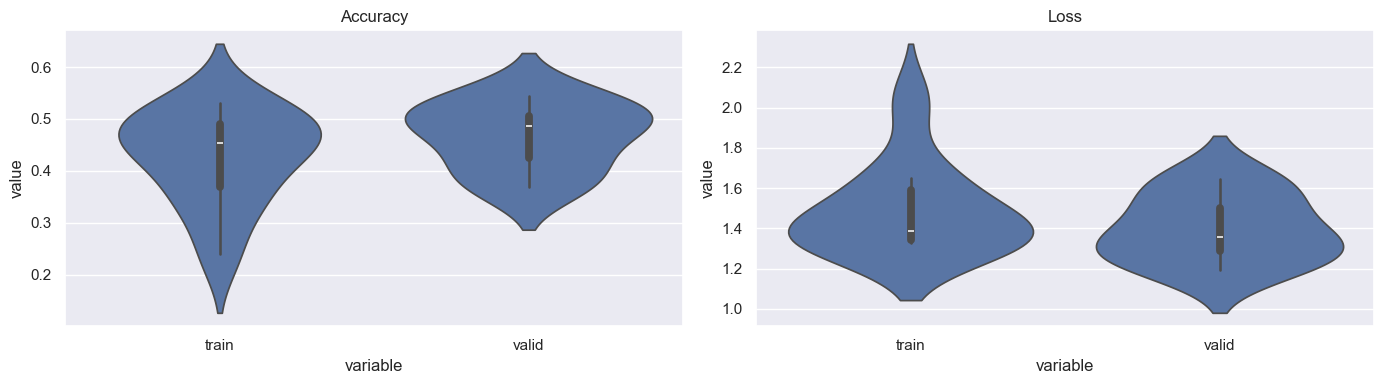

In [50]:
# Create dataframes for accuracy and loss
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

# Create the figure and subplots
fig = plt.figure(figsize=(14, 4))

# Accuracy plot
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu))
plt.title('Accuracy')
plt.tight_layout()

# Loss plot
ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss))
plt.title('Loss')
plt.tight_layout()

# Save the plot and display it
plt.savefig('performance_dist.png')
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step
Total wrong test predictions: 3189


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       495
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       512
           3       0.00      0.00      0.00       899
           4       0.00      0.00      0.00       608
           5       0.11      1.00      0.20       400
           6       0.00      0.00      0.00       620

    accuracy                           0.11      3589
   macro avg       0.02      0.14      0.03      3589
weighted avg       0.01      0.11      0.02      3589



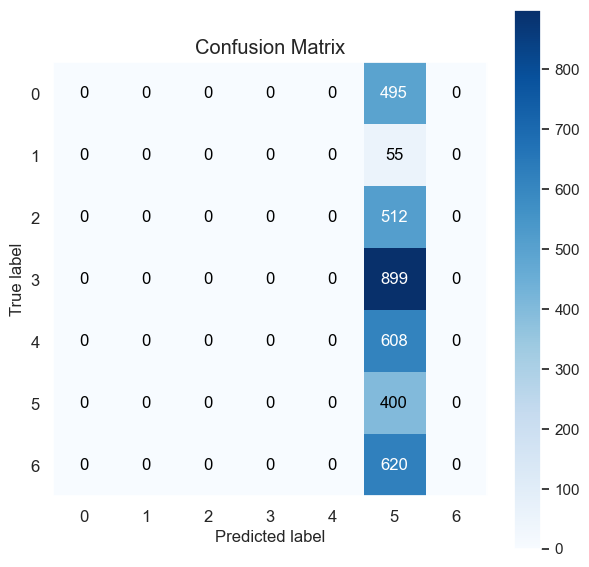

In [53]:
# Predict probabilities for each class using the model
yhat_test = model.predict(X_test)

# Convert probabilities to class labels
yhat_test_classes = np.argmax(yhat_test, axis=1)

# Plot confusion matrix
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_test_classes, figsize=(7, 7))
plt.savefig("confusion_matrix_dcnn.png")

# Print the number of incorrect predictions
print(f'Total wrong test predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test_classes)}\n\n')

# Print classification report with zero_division parameter to handle the warning
print(classification_report(np.argmax(y_test, axis=1), yhat_test_classes, zero_division=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


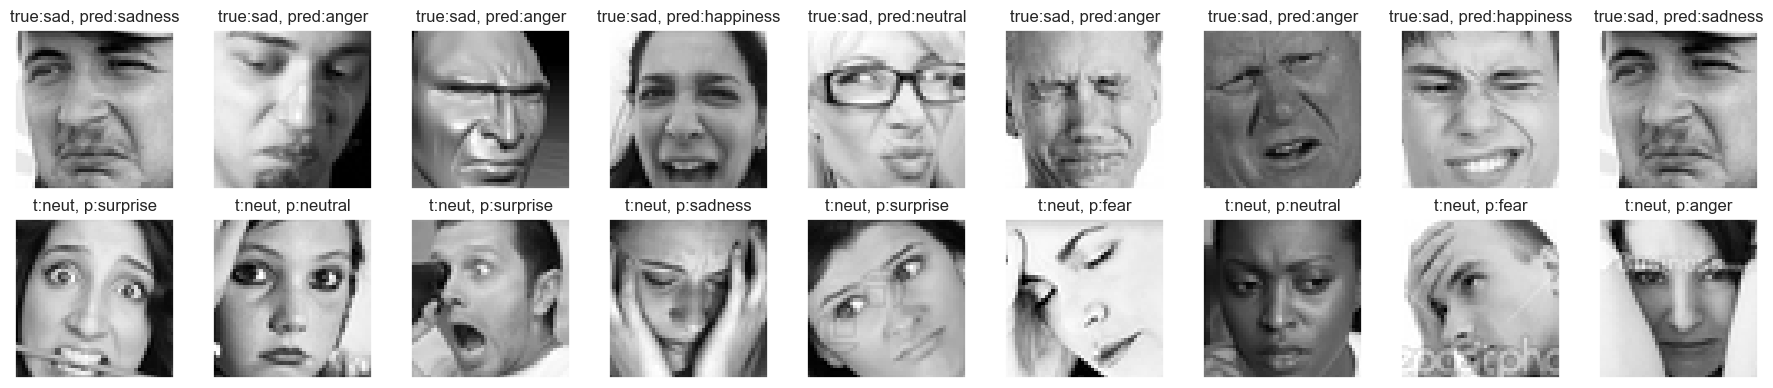

In [56]:
# Set the random seed for reproducibility
np.random.seed(2)

# Randomly select sad and neutral images
random_sad_imgs = np.random.choice(np.where(y_test[:, 4] == 1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_test[:, 6] == 1)[0], size=9)

# Create the figure
fig = plt.figure(1, (18, 4))

# Loop through the selected indices
for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    # Plot sad images
    ax = plt.subplot(2, 9, i + 1)
    sample_img = X_valid[sadidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Predict and get the label for sad images
    pred_sad = model.predict(sample_img.reshape(1, 48, 48, 1))
    predicted_label_sad = emotion_label_to_text[np.argmax(pred_sad)]  # Use np.argmax to get the predicted class index
    ax.set_title(f"true:sad, pred:{predicted_label_sad}")

    # Plot neutral images
    ax = plt.subplot(2, 9, i + 10)
    sample_img = X_valid[neuidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Predict and get the label for neutral images
    pred_neutral = model.predict(sample_img.reshape(1, 48, 48, 1))
    predicted_label_neutral = emotion_label_to_text[
        np.argmax(pred_neutral)]  # Use np.argmax to get the predicted class index
    ax.set_title(f"t:neut, p:{predicted_label_neutral}")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


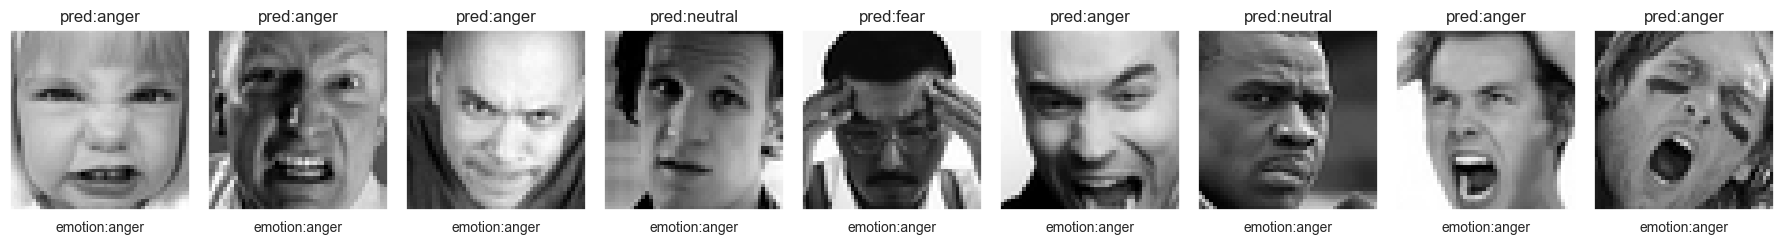

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


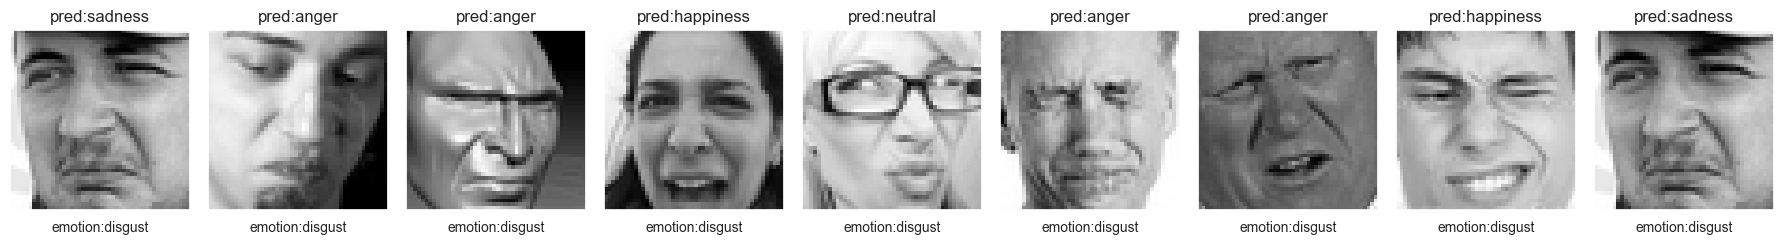

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


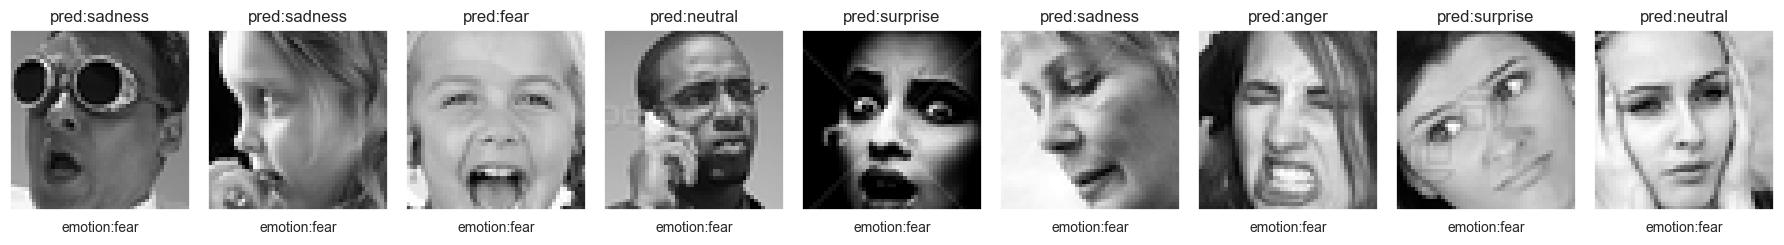

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


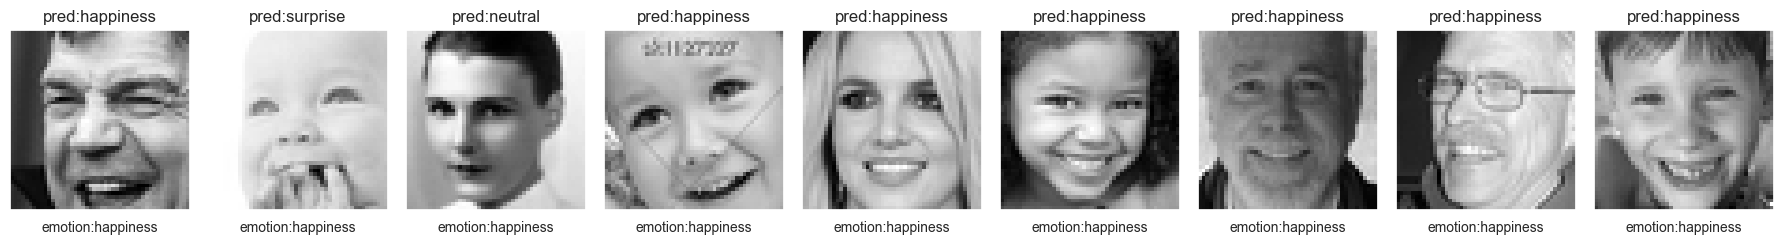

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


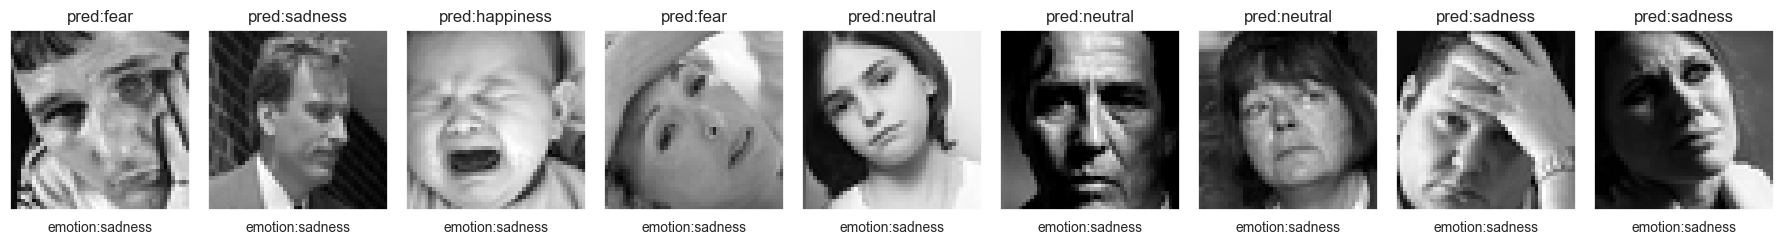

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


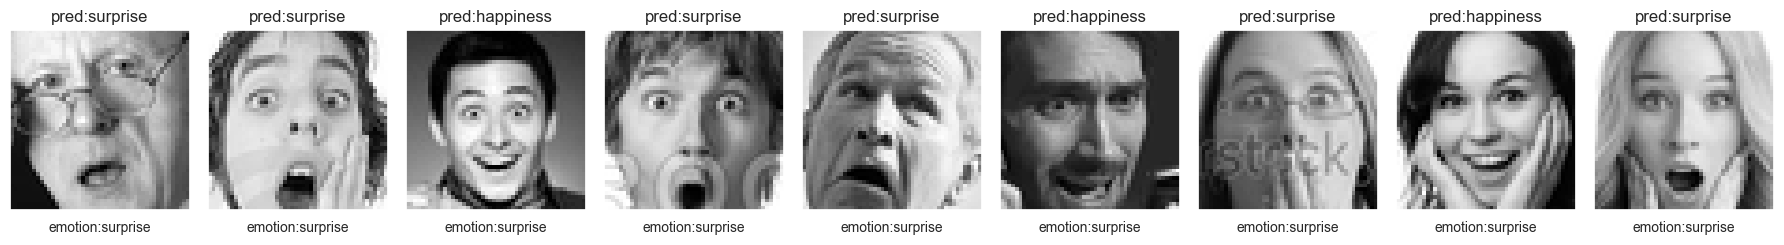

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


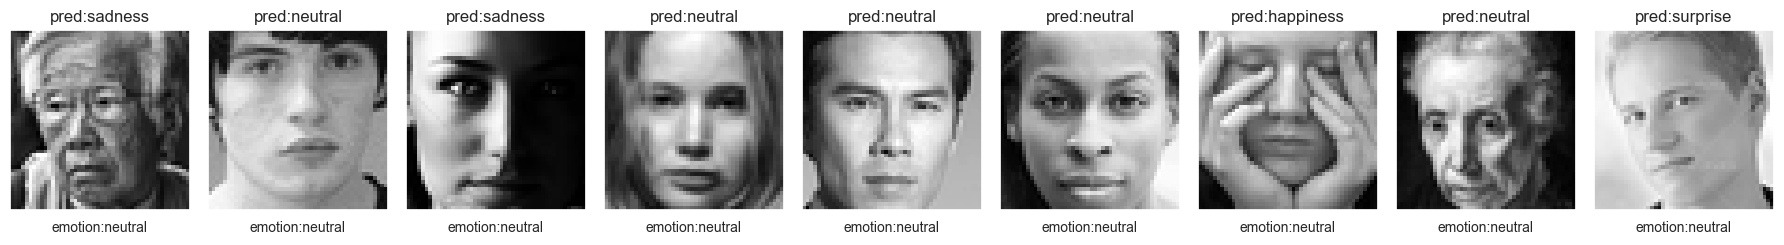

In [64]:
import numpy as np
import matplotlib.pyplot as plt


def plot_random_emotion_predictions(model, X_valid, y_test, emotion_label_to_text, emotion_name, n_images=9, seed=2):
    """
    Function to randomly select and plot images of a specific emotion from the validation set with predicted labels.

    Args:
    - model: The trained model used for predictions.
    - X_valid: The validation images.
    - y_test: The true labels for the validation set.
    - emotion_label_to_text: A dictionary mapping class indices to emotion labels.
    - emotion_name: The emotion (e.g. 'sadness', 'neutral', etc.) to be checked.
    - n_images: Number of images to plot for the selected emotion (default: 9).
    - seed: Random seed for reproducibility (default: 2).
    """
    # Ensure reproducibility with the random seed
    np.random.seed(seed)

    # Find the index of the emotion in the label dictionary
    emotion_idx = [idx for idx, label in emotion_label_to_text.items() if label == emotion_name]

    if not emotion_idx:
        print(f"Emotion '{emotion_name}' not found in the emotion_label_to_text dictionary.")
        return

    emotion_idx = emotion_idx[0]  # Get the first index (since the dictionary is unique)

    # Select random indices for the chosen emotion
    random_emotion_imgs = np.random.choice(np.where(y_test[:, emotion_idx] == 1)[0], size=n_images)

    # Create the figure for plotting
    fig = plt.figure(figsize=(18, 4))

    # Loop through the selected indices and plot
    for i, idx in enumerate(random_emotion_imgs):
        # Plot the image
        ax = plt.subplot(1, n_images, i + 1)
        sample_img = X_valid[idx, :, :, 0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        # Predict and get the label for the current image
        pred = model.predict(sample_img.reshape(1, 48, 48, 1))
        predicted_label = emotion_label_to_text[np.argmax(pred)]  # Get predicted label using np.argmax

        # Set the title with the predicted label
        ax.set_title(f"pred:{predicted_label}")

        # Add the emotion name at the bottom of the image
        ax.text(0.5, -0.1, f"emotion:{emotion_name}", ha='center', va='center', transform=ax.transAxes, fontsize=10)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


for emotion in emotion_label_to_text.values():
    # Call the function to plot for the emotion "--"
    plot_random_emotion_predictions(model, X_valid, y_test, emotion_label_to_text, emotion_name=emotion, n_images=9,
                                    seed=2)
    # break

